In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
class TicTacToe4x4:
    def __init__(self):
        self.board = np.zeros((4, 4), dtype=int)
        
    def reset(self):
        self.board = np.zeros((4, 4), dtype=int)
        
    def is_draw(self):
        return not np.any(self.board == 0)  # No zeros left on the board
    
    def is_winner(self, player):
        # Check rows, columns, and diagonals for a win
        for i in range(4):
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
                
        if np.all(np.diag(self.board) == player) or np.all(np.diag(np.fliplr(self.board)) == player):
            return True
        
        return False
    
    def available_moves(self):
        return np.argwhere(self.board == 0)
    
    def make_move(self, move, player):
        if self.board[move[0], move[1]] == 0:
            self.board[move[0], move[1]] = player
            return True
        return False

    def display(self):
        print(self.board)

In [2]:
def random_player(board, player):
    moves = board.available_moves()
    return random.choice(moves)

In [3]:
def play_game():
    board = TicTacToe4x4()
    current_player = 1
    while True:
        move = random_player(board, current_player)
        board.make_move(move, current_player)
        if board.is_winner(current_player):
            return current_player
        if board.is_draw():
            return 0  # Draw
        current_player = 3 - current_player  # Switch between 1 and 2

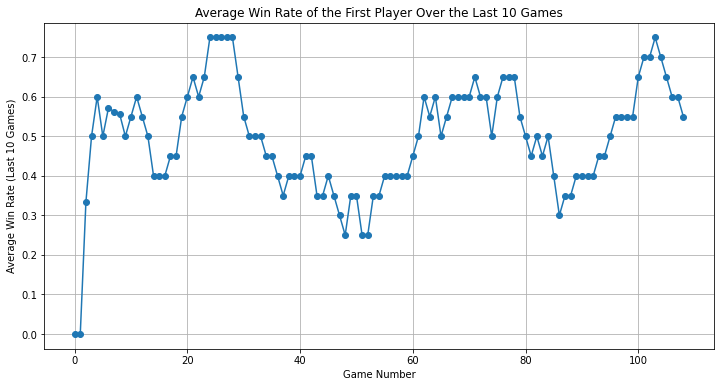

In [4]:
# Play the game 100 times and keep track of the results
results = []
for _ in range(109):
    results.append(play_game())

# Compute the average win rate for the first player over the last ten games
average_win_rates = []
for i in range(len(results)):
    last_ten = results[max(0, i-9):i+1]
    average_win_rates.append((last_ten.count(1) + 0.5 * last_ten.count(0)) / len(last_ten))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(average_win_rates, marker='o', linestyle='-')
plt.xlabel('Game Number')
plt.ylabel('Average Win Rate (Last 10 Games)')
plt.title('Average Win Rate of the First Player Over the Last 10 Games')
plt.grid(True)
plt.show()

In [5]:
# MCTS Node Class
class MCTSNode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = game_state
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.value = 0.0

    # Check if a node is fully explanded
    def is_fully_expanded(self):
        return len(self.children) == len(self.game_state.available_moves())

    # Select the best child based on the UCBT formula. The 1e-7 terms avoid dividing by 0
    def best_child(self, exploration_weight=1.0):
        scores = [
            (child.value / (child.visits + 1e-7) +
             exploration_weight * np.sqrt(np.log(self.visits) / (child.visits + 1e-7)))
            for child in self.children
        ]
        return self.children[np.argmax(scores)]

    # Simulate a playthrough to the end of the game with both players making random moves
    def rollout(self):
        current_board = self.game_state
        current_player = 1 if current_board.board[self.move[0], self.move[1]] == 2 else 2
        while True:
            if current_board.is_winner(current_player):
                return 1 if current_player == 2 else 0
            if current_board.is_draw():
                return 0.5
            move = random_player(current_board, current_player)
            current_board.make_move(move, current_player)
            current_player = 3 - current_player

    # backpropagate the results of a simulated playthrough through the ancestors of a node
    def backpropagate(self, value):
        self.visits += 1
        self.value += value
        if self.parent:
            self.parent.backpropagate(value)

In [6]:
#Here is a stub that you will need to fill out to implement the MCTS code, Code you need to write is marked by ***
# MCTS Algorithm Class
class MCTS:
    # initialize the node's exploration_weight
    def __init__(self, exploration_weight=1.0):
        # *** One line here, finished
        self.exploration_weight = exploration_weight
        

    # search for the best move over 1000 simulations
    def search(self, initial_state, n_simulations=1000):
        #initialize the root to the initial state
        root = MCTSNode(initial_state)
        # for each simulation (up to n_simulations)
        for _ in range(n_simulations):
            # call select on the root node
            node = self._select(root)
            #if the node's game state is a draw or a win for either player, this simulation is done
            if node.game_state.is_draw() or (node.move and node.game_state.is_winner(3 - node.game_state.board[node.move[0], node.move[1]])):
                continue
            # otherwise expand the node to find its children
            # ***One line here, finished
            child = self._expand(node)
            #set the reward to the results of playing out the game from the child node
            # ***One line here, finished
            reward = child.rollout()
            # backpropagate the reward from the child node
            # ***One line here, finished
            child.backpropagate(reward)
        return root.best_child().move

        # While the node is not yet fully expanded, if the node is not a leaf (has children), then find the best child
    def _select(self, node):
        while not node.is_fully_expanded():
            if node.children:
                #update the node to its best child, given the exploration weight
                # *** One line here, finished
                node = node.best_child(self.exploration_weight)
            else:
                return node
        return node
    #choose a node to expand randomly
    def _expand(self, node):
        untried_moves = set(tuple(move) for move in node.game_state.available_moves()) - set(child.move for child in node.children)
        move = random.choice(list(untried_moves))
        child_game_state = TicTacToe4x4()
        child_game_state.board = node.game_state.board.copy()
        child_game_state.make_move(move, 3 - node.game_state.board[node.move[0], node.move[1]] if node.move else 1)
        child_node = MCTSNode(child_game_state, parent=node, move=move)
        node.children.append(child_node)
        return child_node

In [7]:
# Player Functions
def random_player(board, player):
    moves = board.available_moves()
    return random.choice(moves)

def mcts_player(board, player):
    mcts = MCTS()
    return mcts.search(board)

In [8]:
# Game Playing Loop with MCTS for Player X
def play_game_mcts():
    board = TicTacToe4x4()
    current_player = 1
    while True:
        if current_player == 1:
            # Choose the move using the mcts_player function
            # *** One line here, finished
            move = mcts_player(board, current_player)
        else:
            move = random_player(board, current_player)
        board.make_move(move, current_player)
        if board.is_winner(current_player):
            return current_player
        if board.is_draw():
            return 0
        current_player = 3 - current_player

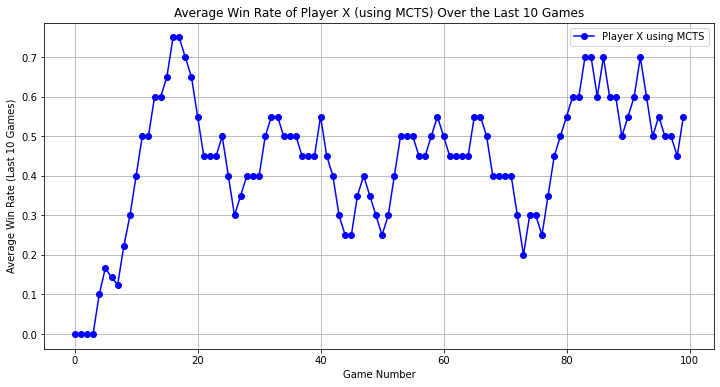

In [9]:
# Running the Experiment
results_mcts = []
for _ in range(100):
    results_mcts.append(play_game_mcts())

average_win_rates_mcts = []
for i in range(len(results_mcts)):
    last_ten = results_mcts[max(0, i-9):i+1]
    # Append the average win rates over the last ten games assigning 1 for a win and .5 for a draw
    # *** One line here
    average_win_rates_mcts.append((last_ten.count(1) + 0.5 * last_ten.count(0)) / len(last_ten))

# Plotting the Results
plt.figure(figsize=(12, 6))
plt.plot(average_win_rates_mcts, marker='o', linestyle='-', color='blue', label='Player X using MCTS')
plt.xlabel('Game Number')
plt.ylabel('Average Win Rate (Last 10 Games)')
plt.title('Average Win Rate of Player X (using MCTS) Over the Last 10 Games')
plt.grid(True)
plt.legend()
plt.show()

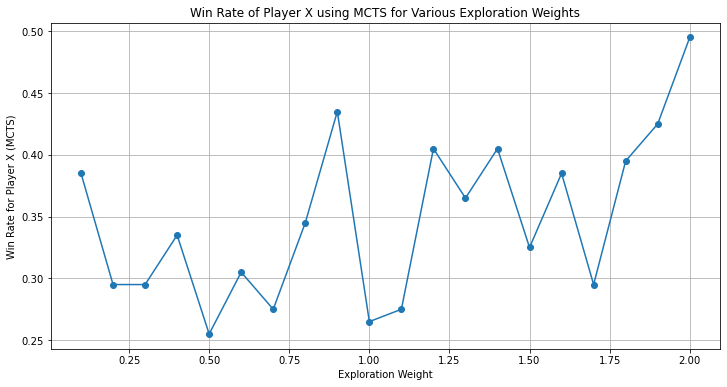

In [10]:
# Perform some experiments to find the optimal value of the exploration_weight in best_child
# Exploration for Optimal Exploration Weight
exploration_weights = np.linspace(0.1, 2, 20)  # Test values from 0.1 to 2, 20 points in total
win_rates_for_weights = []

# For each weight in exploration_weights
#   initialize results_for_weight to be empty
#   For each of 100 games
#      call MCTS with the current exploration weight
#      append the results of play_game_mcts to the current results_for_weight
#   calculate the win rate actoss all results_for_weight, assigning 1 for a win and .5 for a draw
#   Append the win rate for the current weight to win_rate_for_weights

# *** 7 lines here
for weight in exploration_weights:
    results_for_weight = []
    for _ in range(100):
        mcts = MCTS(exploration_weight = weight)
        results_for_weight.append(play_game_mcts())
    win_rate = (results_for_weight.count(1) + 0.5 * last_ten.count(0)) / len(results_for_weight)
    win_rates_for_weights.append(win_rate)

   

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(exploration_weights, win_rates_for_weights, marker='o', linestyle='-')
plt.xlabel('Exploration Weight')
plt.ylabel('Win Rate for Player X (MCTS)')
plt.title('Win Rate of Player X using MCTS for Various Exploration Weights')
plt.grid(True)
plt.show()

optimal_weight = exploration_weights[np.argmax(win_rates_for_weights)]

In [11]:
optimal_weight

2.0

In [12]:
win_rates_for_weights[np.argmax(win_rates_for_weights)]

0.495

In [15]:
'''

#Here is a stub that you will need to fill out to implement the MCTS code, Code you need to write is marked by ***
# MCTS Algorithm Class
class MCTS:
    # initialize the node's exploration_weight
    def __init__(self, exploration_weight=1.7):
        # *** One line here, finished
        self.exploration_weight = exploration_weight
        self.root = None

    # search for the best move over 1000 simulations
    def search(self, initial_state, n_simulations=1000):
        #initialize the root to the initial state
        if root is None:
            self.root = MCTSNode(initial_state)
        # for each simulation (up to n_simulations)
        for _ in range(n_simulations):
            # call select on the root node
            node = self._select(root)
            #if the node's game state is a draw or a win for either player, this simulation is done
            if node.game_state.is_draw() or (node.move and node.game_state.is_winner(3 - node.game_state.board[node.move[0], node.move[1]])):
                continue
            # otherwise expand the node to find its children
            # ***One line here, finished
            child = self._expand(node)
            #set the reward to the results of playing out the game from the child node
            # ***One line here, finished
            reward = child.rollout()
            # backpropagate the reward from the child node
            # ***One line here, finished
            child.backpropagate(reward)
            
            
            best = self.root.best_child()
            self.root = best
            
        return root.best_child().move

        # While the node is not yet fully expanded, if the node is not a leaf (has children), then find the best child
    def _select(self, node):
        while not node.is_fully_expanded():
            if node.children:
                #update the node to its best child, given the exploration weight
                # *** One line here, finished
                node = node.best_child(self.exploration_weight)
            else:
                return node
        return node
    #choose a node to expand randomly
    def _expand(self, node):
        untried_moves = set(tuple(move) for move in node.game_state.available_moves()) - set(child.move for child in node.children)
        move = random.choice(list(untried_moves))
        child_game_state = TicTacToe4x4()
        child_game_state.board = node.game_state.board.copy()
        child_game_state.make_move(move, 3 - node.game_state.board[node.move[0], node.move[1]] if node.move else 1)
        child_node = MCTSNode(child_game_state, parent=node, move=move)
        node.children.append(child_node)
        return child_node
    
'''

"\n\n#Here is a stub that you will need to fill out to implement the MCTS code, Code you need to write is marked by ***\n# MCTS Algorithm Class\nclass MCTS:\n    # initialize the node's exploration_weight\n    def __init__(self, exploration_weight=1.7):\n        # *** One line here, finished\n        self.exploration_weight = exploration_weight\n        self.root = None\n\n    # search for the best move over 1000 simulations\n    def search(self, initial_state, n_simulations=1000):\n        #initialize the root to the initial state\n        if root is None:\n            self.root = MCTSNode(initial_state)\n        # for each simulation (up to n_simulations)\n        for _ in range(n_simulations):\n            # call select on the root node\n            node = self._select(root)\n            #if the node's game state is a draw or a win for either player, this simulation is done\n            if node.game_state.is_draw() or (node.move and node.game_state.is_winner(3 - node.game_state.boar